In [1]:
# System imports
import sys
sys.path.append("../")

# Module imports
import numpy as np
import matplotlib.pyplot as plt

# FscoreAI imports
from sample_data import sample_data

# Simple Linear Regression

Assume a dataset $\{\mathbf{X}, \mathbf{Y}\}$
$$
	\mathbf{X} = \begin{bmatrix}
	x^{(1)} & \dots & x^{(n)}\\
	\end{bmatrix}
	\text{,}\qquad
	\mathbf{Y} = \begin{bmatrix}
	y^{(1)} & \dots y^{(n)}\\
	\end{bmatrix}
$$
where the discrete or continuous independent variable (also called the input, predictor, or covariate) $\mathbf{X} \in \mathbb{R}^{n}$ and the continuous dependent variable (also called the output, target, label, or response variable) $\mathbf{Y} \in \mathbb{R}^{n}$, $n$ is the number of training examples. We wish to use a supervised learning approach for a regression application by learning a model hypothesis $h_\theta(\mathbf{x}^{(i)})$ which predicts $\hat y^{(i)}$ given ${x}^{(i)}$, assuming the relationship between the two is linear.

## Data

Let's start by creating a dummy dataset using our pre-built `simulate_linear_data` helper function.

(1000, 1) (1000, 1)


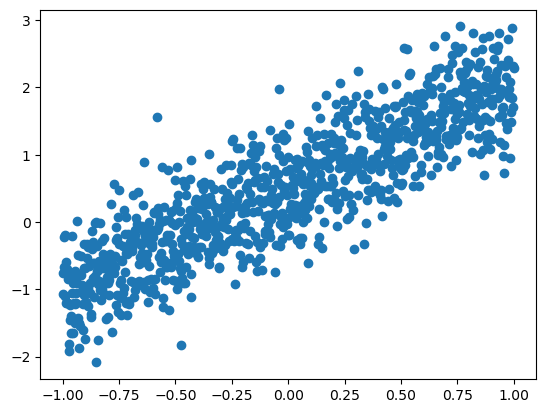

In [2]:
# Create a sample linear data
num_samples = 1000
X, y = sample_data.simulate_linear_data(n=num_samples, beta_0=0.5, beta_1=1.5)
print(X.shape, y.shape)

# Display sample data
plt.scatter(X, y)

## Model
We can see that the data may be a bit noisy, but it is pretty linear in nature. Since we assume that the relationship between the predictor variable and the target variable is linear, we can try finding the best-fit line that, as the name suggests, tries best to describes the trend of the data. This is also called a regression line. Recall the formula for a line from Middle School Algebra 

$$\boxed{h_\theta(x^{(i)}) = y^{(i)} = \theta_1x^{(i)}+\theta_0}$$

Here, $\theta_0$ is also called the bias or the intercept, and it represents the average output of the model when all $\mathbf{x}^{(i)} = 0$.

$\theta_1$, also called the coefficient or slope, represents the average effect of one-unit increase of $x$ on $y$.

Because we created this dataset ourselves, we already know the values of $\theta_0$ and $\theta_1$ in this example. We set them above as $\theta_0 = 0.5$ and $\theta_1 = 1.5$. But for most linear data in the real world, we will have no idea on what these values are. So, let's forget that we know these parameter values, and assume some default values for our best-fit line and try to figure out the real values mathematically.

Note that the term $\theta_0$ makes the function affine.


In [3]:
# Default assumptions for the purpose of this example
theta_0 = 0
theta_1 = 1

# Model predictions
y_preds = (theta_1 * X) + theta_0

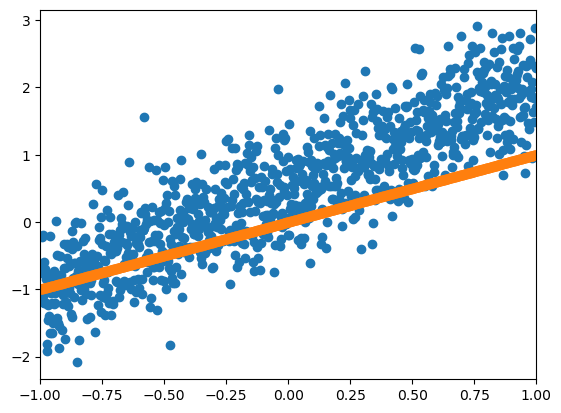

In [4]:
plt.xlim(-1, 1)
plt.scatter(X, y)
plt.scatter(X, y_preds)

Above we can see that our orange line kind of fits the data, but we can do better. To understand how well our line fits the data, we must figure out a way to mathematically quanitfy the "performance" of our model. To do so, let's talk about Loss Functions.

 ## Loss Function
 In order to quantify how well our model performs, we must define a function that compares the predicted output values $\hat y$ to the actual output values $y$. We will call such a function the "loss" function. One way to define the loss is to calculate the distance between the two values. Let's call this distance the "residual" $r$, where 
$$
r^{(i)} = y^{(i)} - \hat{y}^{(i)}
$$
We would like each training example's residual to be as close to zero as possible.

In [5]:
residuals = (y - y_preds)
residuals[:5]

array([[ 0.24835708],
       [-0.06813115],
       [ 0.32584627],
       [ 0.76451793],
       [-0.11307268]])

To quantify how well our model as a whole performs, let's find the average residuals over all our training examples, we shall call this function our "cost" function. We can do so by summing up the absolute values of our residuals and dividing the sum by the number of examples $n$. This method is called Mean Absolute Error (MAE). The caveat with using MAE is that absolute values are non-differentiable functions, which are not desirable for taking derivatives (which we would eventually need to take for training this model using gradient descent). Instead, we can choose to average the sum of squared residuals. This will keep the function differentiable, with an added benefit of penalizing larger losses over smaller ones. This function is also called Mean Squared Error (MSE) and is as follows:
$$
	\boxed{\mathcal{E} = \frac{1}{n}\sum_{i=1}^n{r^{(i)}}^2}
$$
Note: Dividing the sum of squared residuals by $n$ gives us a biased estimate of the variance of the unobserved errors. To remove the bias, divide the sum of squared residuals by $\mathrm{df} = n - d - 1$ where $\mathrm{df}$ is the degrees of freedom, and $d$ is the number of parameters being estimated (excluding the intercept). You will understand this more when we talk about multiple linear regression.

In [6]:
# MSE Loss
def MSELoss(y, y_preds):
    residuals = (y - y_preds)**2
    return np.sum(residuals) / num_samples
print(MSELoss(y, y_preds))

0.5927712565390625


## Training
Now that we are able to figure out how well our model as a whole performs, we would like to try to not "guesstimate" the $\theta$ parameters, but mathematically find the best ones that lead us to the least amount of loss. We can do this using multiple methods. Let's look at these one at a time. 

### Closed-form/Direct Solution
Recall from single variable calculus that (assuming a function is differentiable) the minimum $x^*$ of a function $f$ has the property that the derivative $\frac{\mathrm{d}f}{\mathrm{d}x}$ is zero at $x = x^*$. Note that the converse is not true: if $\frac{\mathrm{d}f}{\mathrm{d}x} = 0$, then $x^*$ might be a maximum or an inflection point, rather than a minimum. But the minimum can only occur at points that have derivative zero.

We will use this information to find the parameters that minimize our cost in the case of a simple/univariate data distributions. 

To do so, let's take the partial derivative of the cost function with respect to the parameters $\theta_0$ and $\theta_1$, set the derivatives equal to zero, and then solve for our estimated parameters $\hat\theta_0$ and $\hat\theta_1$.

**Taking the partial derivative w.r.t. $\hat\theta_0$**
\begin{align*}
	\frac{\delta\mathcal{E}}{\delta{\hat\theta_0}}&=\frac{\delta}{\delta{\hat\theta_0}}\frac{1}{n}\sum_{i=1}^n \left(y^{(i)} - \hat y^{(i)}\right)^2
    \\
    & = \frac{\delta}{\delta{\hat\theta_0}}\frac{1}{n}\sum_{i=1}^n \left[y^{(i)} - \left(\hat\theta_0 + \hat\theta_1 x^{(i)}\right)\right]^2
    \\
    & = \frac{-2}{n}\sum_{i=1}^n \left(y^{(i)} - \hat\theta_0 - \hat\theta_1 x^{(i)}\right)
    \\
    & = \frac{-2}{n}\left(\sum_{i=1}^ny^{(i)} - n\hat\theta_0-\hat\theta_1\sum_{i=1}^nx^{(i)}\right)
    \\
    & = -2\left(\frac{n}{n}\hat\theta_0+\hat\theta_1\frac{1}{n}\sum_{i=1}^nx^{(i)}-\frac{1}{n}\sum_{i=1}^ny^{(i)}\right)
    \\
    & = -2\left(\hat\theta_0+\hat\theta_1\bar x-\bar y\right)
\end{align*}

**Setting the partial derivative to 0 and solving for $\hat\theta_0$:**
\begin{align*}
	-2\left[\hat\theta_0+\hat\theta_1\bar x-\bar y\right] &= 0
    \\
    \hat\theta_0 &= \bar{y} - \hat\theta_1\bar{x}                      
\end{align*}

**Taking the partial derivative of $\hat\theta_1$:**
\begin{align*}
	\frac{\delta\mathcal{E}}{\delta{\hat\theta_1}} &= \frac{\delta}{\delta{\hat\theta_1}}\frac{1}{n}\sum_{i=1}^n \left(y^{(i)} - \hat y^{(i)}\right)^2
    \\
    & = \frac{\delta}{\delta{\hat\theta_1}}\frac{1}{n}\sum_{i=1}^n \left(y^{(i)} - \left(\hat\theta_0 + \hat\theta_1 x^{(i)}\right)\right)^2
    \\
    & = \frac{-2}{n}\sum_{i=1}^n (x^{(i)})\left(y^{(i)} - \hat\theta_0 - \hat\theta_1 x^{(i)}\right)
    \\
    & = \frac{-2}{n}\sum_{i=1}^n \left(x^{(i)}y^{(i)} - (\bar{y} - \hat\theta_1\bar{x}) x^{(i)}- \hat\theta_1 {x^{(i)}}^2\right)
    \\
    & = \frac{-2}{n}\left( \sum_{i=1}^n x^{(i)}y^{(i)} - \bar{y}\sum_{i=1}^nx^{(i)} + \hat\theta_1\bar{x}\sum_{i=1}^nx^{(i)}- \hat\theta_1 \sum_{i=1}^n{x^{(i)}}^2 \right)
\end{align*}

**Setting the partial derivative to 0 and solving for $\hat\theta_1$:**
\begin{align*}
    \left( -\sum_{i=1}^n x^{(i)}y^{(i)} + \bar{y}\sum_{i=1}^nx^{(i)} - \hat\theta_1\bar{x}\sum_{i=1}^nx^{(i)} +  \hat\theta_1 \sum_{i=1}^n{x^{(i)}}^2 \right) &= 0
\end{align*}
\begin{align*}
    \hat\theta_1 \left(\bar{x}\sum_{i=1}^nx^{(i)}-\sum_{i=1}^n{x^{(i)}}^2\right) &= \bar{y} \sum_{i=1}^nx^{(i)} - \sum_{i=1}^nx^{(i)}y^{(i)}
    \\
    \hat\theta_1 &= \frac{\bar{y} \sum_{i=1}^nx^{(i)} - \sum_{i=1}^nx^{(i)}y^{(i)}}{\bar{x}\sum_{i=1}^nx^{(i)}-\sum_{i=1}^n{x^{(i)}}^2}
    \\
    &= \frac{n\bar{y} \bar x - \sum_{i=1}^nx^{(i)}y^{(i)}}{n\bar{x}^2-\sum_{i=1}^n{x^{(i)}}^2}
    \\
    &= \frac{\sum_{i=1}^nx^{(i)}y^{(i)} - n\bar{y} \bar x}{\sum_{i=1}^n{x^{(i)}}^2 - n\bar{x}^2}
\end{align*}

**To simplify:**
\begin{align*}
\sum_{i=1}^nx^{(i)}y^{(i)} - n\bar{y} \bar x &= \sum_{i=1}^n(x^{(i)}-\bar x)(y^{(i)} - \bar{y}) := \mathrm{S_{XY}}
    \\
	\sum_{i=1}^n{x^{(i)}}^2 - n\bar{x}^2 & = \sum_{i=1}^n(x^{(i)} - \bar{x})^2 := \mathrm{S_{XX}}
\end{align*}

$$\boxed{\hat\theta_1 = \frac{\mathrm{S_{XY}}}{\mathrm{S_{XX}}}}$$

$$\boxed{\hat\theta_0 = \bar y - \frac{\mathrm{S_{XY}}}{\mathrm{S_{XX}}}\bar x}$$

The above two equations give us a method to analytically solve for the $\theta$ parameters that will give us the least amount of MSE Loss, thus giving us all the tools we need to find the best-fit line. Let's wrap all the above in a near class that we can then improve and expand on. 

In [7]:
class LinearRegression():
    def __init__(self):
        # Hard-coded default values
        self.coef_ = np.array([1, -1])
        self.intercept_ = 0
    
    def fit(self, X, y):
        num_samples = X.shape[0]
        X_mean = np.sum(X) / num_samples
        y_mean = np.sum(y) / num_samples
        S_XY = 0
        S_XX = 0
        for sample in range(num_samples):
            S_XY += (X[sample] - X_mean) * (y[sample] - y_mean)
            S_XX += (X[sample] - X_mean)**2
        self.intercept_ = y_mean - (S_XY / S_XX * X_mean)
        self.coef_ = S_XY / S_XX
    
    def predict(self, X):
        num_samples = X.shape[0]
        preds = []
        for sample in range(num_samples):
            y_preds = self.coef_ * X[sample]
            preds.append(y_preds + self.intercept_)
        return np.array(preds).reshape(-1, 1)

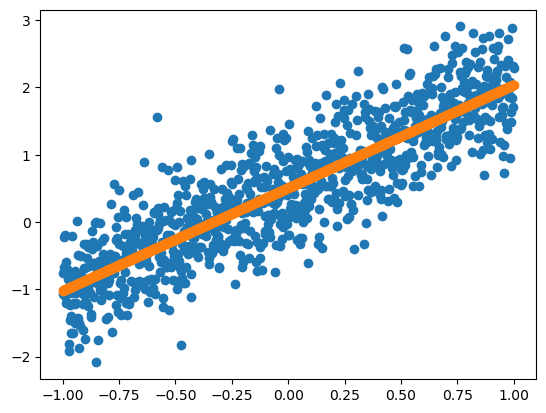

In [8]:
model = LinearRegression()
model.fit(X, y)
y_preds = model.predict(X)

plt.scatter(X, y)
plt.scatter(X, y_preds)

Let's find the value we get for our MSE Loss.

In [9]:
print(MSELoss(y, y_preds))

0.23917472439094223


You can see the loss is much lower than the loss we got previously. 

Now that we can find the best-fit line in the case of univariate data, let's try to up our game by finding out the best fit "plane" for multivariate data.

# Multivariate Linear Regression

We can represent multivariate datasets using the following design matrices:
$$
	\mathbf{X} = \begin{bmatrix}
	x^{(1)}_{1} & \dots & x^{(1)}_{d}\\
	\vdots & \ddots & \vdots \\
	x^{(n)}_{1} & \dots & x^{(n)}_{d}
	\end{bmatrix}
	\text{,}\qquad
	\mathbf{Y} = \begin{bmatrix}
	y^{(1)}\\
	\vdots\\
	y^{(n)}
	\end{bmatrix}
$$
where the input $\mathbf{X} \in \mathbb{R}^{n\times d}$ and the output $\mathbf{Y} \in \mathbb{R}^{n\times 1}$. $d$ is the number of features and like before, $n$ is the number of training examples.  

## Data
We can now use our `simulate_multilinear_data` function to create a training dataset with mutliple features. 

(1000, 2) (1000, 1)


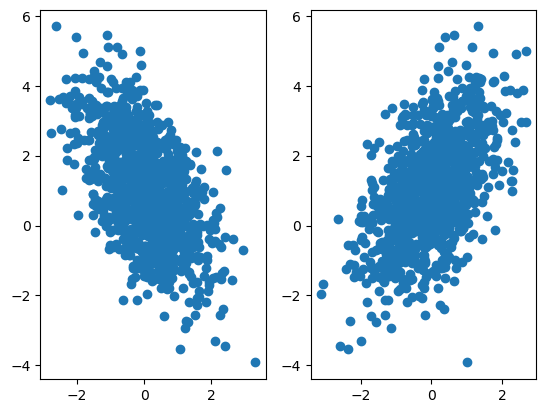

In [10]:
# Create a sample linear data for demonstration purposes
num_samples = 1000
num_features = 2
X, y = sample_data.simulate_multilinear_data(n=num_samples, d=num_features, seed=2023)
print(X.shape, y.shape)

# Display sample data
fig, ax = plt.subplots(1,2)
ax[0].scatter(X[:,0], y)
ax[1].scatter(X[:,1], y)

## Model
Since the relationship between the input and the output is linear, we can use the following function to describe the model for the $i$-th example:
$$
	\boxed{h_\theta(\mathbf{x}^{(i)}) = \theta_0 + \theta_1 x^{(i)}_{1} + \dots + \theta_d x^{(i)}_{d} = \theta_0 + \sum_{j=1}^d\theta_j  x^{(i)}_{j}}
$$
where $i = (1,\dots,n)$, $j = (1,\dots,d)$, $\theta_0$ is the bias and $\theta_j$ representst the coefficient of a specific feature. Let's update the `predict` function in our `LinearRegression` class to accomodate predictions on multivariate data. 

In [19]:
class LinearRegression():
    def __init__(self):
        # Hard-coded default values
        self.coef_ = np.array([1, -1])
        self.intercept_ = 0
    
    def fit(self, X, y):
        num_samples = X.shape[0]
        X_mean = np.sum(X) / num_samples
        y_mean = np.sum(y) / num_samples
        S_XY = 0
        S_XX = 0
        for sample in range(num_samples):
            S_XY += (X[sample] - X_mean) * (y[sample] - y_mean)
            S_XX += (X[sample] - X_mean)**2
        self.intercept_ = y_mean - (S_XY / S_XX * X_mean)
        self.coef_ = S_XY / S_XX
    
    def predict(self, X):
        num_samples, num_features = X.shape[0], X.shape[1]
        y_preds = []
        for sample in range(num_samples):
            y_pred = 0
            for feature in range(num_features):
                y_pred += self.coef_[feature] * X[sample, feature]
            y_preds.append(y_pred + self.intercept_)
        return np.array(y_preds).reshape(-1, 1)

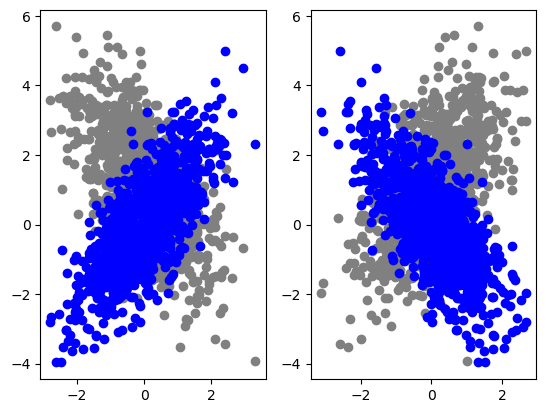

In [20]:
# Example
model = LinearRegression()
y_preds = model.predict(X)

fig, ax = plt.subplots(1,2)
ax[0].scatter(X[:,0], y, c="gray")
ax[0].scatter(X[:,0], y_preds, c="blue")

ax[1].scatter(X[:,1], y, c="gray")
ax[1].scatter(X[:,1], y_preds, c="blue")

In [21]:
print(MSELoss(y, y_preds))

8.456934198248142


## Training
Now that we have updated our linear model, along with previously having a function to eingvaluate how well it performs, we can try find the optimal values of our parameters $\theta$ using a similar analytical, closed-form, approach. Note: The analytical solution that we developed is a unique case to simple linear regression. Most machine learning models do not have analytical solutions since they are non-linear. We will also take a look at optimizing our parameters using Gradient Descent and Maximum Likelihood Estimation to get a better understanding of those.

### Closed-form/Direct Solution
To find a closed-form solution to multivariate linear regression, let's use a vectorized approach. We will first need to augment our augment our design matrix to incorporate the bias term in $\mathbf{X}$:
$$
	\mathbf{X} = \begin{bmatrix}
	1 & x^{(1)}_{1} & \dots & x^{(1)}_{d}\\
	\vdots & \ddots & \vdots \\
	1 & x^{(n)}_{1} & \dots & x^{(n)}_{d}
	\end{bmatrix}
$$
where $\mathbf{X} \in \mathbb{R}^{n\times (d+1)}$

Notice that we have added a column of 1's in $\mathbf{X}$. Our $\theta$ matrix now looks like this:
$$
	\theta = \begin{bmatrix}
	\theta_0 & \dots & \theta_{d}\\
	\end{bmatrix}
$$
where $\theta \in \mathbb{R}^{d+1}$

Now we can revisit our hypothesis function which can be rewritten as the follows:
\begin{align}
    h(x^{(i)}) &= \sum_{j=0}^d\theta_j x_j^{(i)}
    \\
    h_\theta(x) &= \mathbf{X}\theta
\end{align}

Now our cost function can be rewritten as follows:
\begin{align*}
\mathcal{E}(\theta) &= \frac{1}{n}\sum_{i=1}^n({h_\theta(x^{(i)}) - y^{(i)}})^2
\\
&= \frac{1}{n}\sum_{i=1}^n({y_i - \mathbf{x}_i\theta})^2
\\
&= \frac{1}{n}(\theta^\top x^{(i)} - y^{(i)})^2
\\
&= \frac{1}{n}(\mathbf{X}\theta - y)^\top (\mathbf{X}\theta - y)
\end{align*}

Now we can take the partial derivative of the loss function with respect to $\theta$ and set it equal to zero to find the minima
\begin{align*}
\mathcal{E}(\theta) &= \frac{1}{n}(\mathbf{X}\theta - y)^\top(X\theta - y)
\\
&\propto \theta^\top X^\top X\theta - y^\top X\theta - \theta^\top X^\top y + y^\top y
\\
&\propto \theta^\top X^\top X\theta - 2\theta^\top X^\top y + y^\top y
\end{align*}
Take the derivative and set equal to 0, then solve for $\theta$:

\begin{align}
\frac{\delta}{\delta\theta}(\theta^\top X^\top X\theta - 2\theta^\top X^\top y + y^\top y) &= 0
\\
(X^\top X)\theta - X^\top y &= 0
\\
(X^\top X)\theta &= X^\top y
\\
\theta &= (X^\top X)^{-1}X^\top y
\end{align}

If $X^\top X$ is not invertible, you can use pseudo-inverse instead of the inverse by using `numpy.linalg.pinv(a)`. Also, make sure to remove redundant (non-linearly dependent) features, and maintain $d \le n$. Now, let's incorporate the above in our `LinearRegression` class.

In [25]:
# Vectorized
class LinearRegression():
    def __init__(self):
        # Hard-coded default values
        self.coef_ = np.array([1, -1])
        self.intercept_ = 0
        
    def fit(self, X, y):
        n, d = X.shape
        X = np.hstack((np.ones((n, 1)), X))
        self.weights_ = np.linalg.inv(X.T@X) @ (X.T@y)
        self.intercept_ = self.weights_[0]
        self.coef_ = self.weights_[1:]
        return
    
    def predict(self, X):
        num_samples, num_features = X.shape[0], X.shape[1]
        y_preds = []
        for sample in range(num_samples):
            y_pred = 0
            for feature in range(num_features):
                y_pred += self.coef_[feature] * X[sample, feature]
            y_preds.append(y_pred + self.intercept_)
        return np.array(y_preds).reshape(-1, 1)

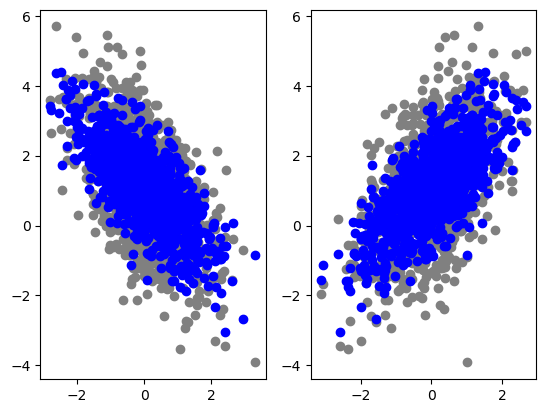

In [26]:
model = LinearRegression()
y_preds = model.fit(X, y)
y_preds = model.predict(X)


fig, ax = plt.subplots(1,2)
ax[0].scatter(X[:,0], y, c="gray")
ax[0].scatter(X[:,0], y_preds, c="blue")

ax[1].scatter(X[:,1], y, c="gray")
ax[1].scatter(X[:,1], y_preds, c="blue")

We can see above that our model is able to fit the data quite well. Let's try to quantify our fit using Mean Squared Error.

In [27]:
print(MSELoss(y, y_preds))

0.9655353524555044


## Evaluation
We can see this value is much lower than the one we previously predicted. MSE Loss is nice, but it is very context-specific. We would like to find better ways to understand the fit of our model. Let's look into some Evaluation techniques that will help us understand our model in different ways.

### Residuals Plot
Residual plots expose a biased model than any other evaluation metric. A residual plot is typically used to find problems with regression. Some data sets are not good candidates for regression, including:

- Heteroscedastic data (points at widely varying distances from the line).
- Data that is non-linearly associated.
- Data sets with outliers.

These problems are more easily seen with a residual plot than by looking at a plot of the original data set. Ideally, residual values should be equally and randomly spaced around the horizontal axis.

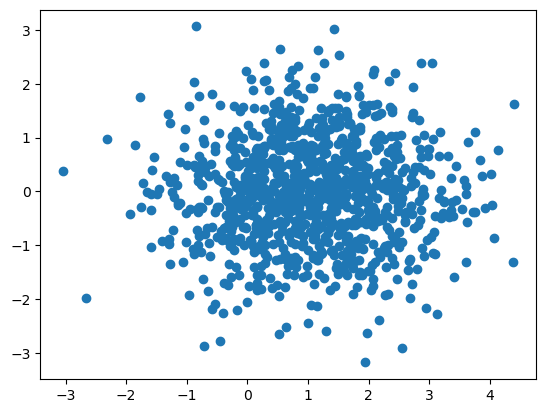

In [38]:
# Residual Plot
residuals = y_preds - y
plt.scatter(y_preds, residuals)

### Coefficient of Determination ($R^2$)
In statistics, the coefficient of determination, denoted $R^2$ or $r^2$ and pronounced "R squared", is the proportion of the variation in the dependent variable that is predictable from the independent variable(s). 

$R^2$ helps us find the measure of a good fit compared to the measure of a bad fit

This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.

Calculated using residuals
- SS(fit): Square the residuals and add them up. Basically, you sum the squares of the residuals around the best fitting line
- Compare the SS(mean)
- SS(mean): sum the squares of the residuals around the worst fitting line (mean of y-axis)

$R^2 = \frac{SS(mean) - SS(fit)}{SS(mean)}$

- It is the percentage of variation around the mean that goes away when you fit a line to the data
- R-Square goes from 0 to 1

In [40]:
def r_squared(true, predicted):
    true = np.squeeze(true)
    predicted = np.squeeze(predicted)

    assert true.ndim == 1
    assert predicted.ndim == 1

    n = true.shape[0]
    true_mean = np.sum(true, axis=0)/n
    
    SSR = np.sum((true - predicted)**2)
    SSM = np.sum((true - true_mean)**2)    
    
    return 1 - (SSR / SSM)

In [41]:
r_squared(y, y_preds)

0.5833504011653348

## Interpreting coefficients with an example
![[Pasted image 20221211153926.png]]
Above is an example of an output from a linear regression model. 

We can interpret the `RM` coefficient (9.1021 in this case) by first noticing that the p-value (under `P>|t|`) is very small, basically zero. This means that the independent variable `RM` is a statistically significant predictor of `PRICE`, at least in this model. 

The regression coefficient for `RM` of 9.1021 means that on average, each additional room is associated with an increase of $9,100 in house price, net of the other variables. The confidence interval gives us a range of plausible values for this average change, about ($8,279, $9,925).

In general, the $\hat\beta_i, i>0$ can be interpreted as the following: "A one unit increase in $x_i$ is associated with, on average, a $\hat\beta_i$  increase/decrease in $y$ net of all other variables." On the other hand, the interpretation for the intercept, $\hat\beta_0$  is the average of $y$ given that all of the independent variables $x_i$ are 0.

## Criteria and Assumptions
- Linearity: The model assumes that there is a linear relationship between the independent and the dependent variables. This can be verified with a scatterplot of each $X$ vs. $Y$ and plotting correlations among $X$. Nonlinearity can sometimes be resolved by transforming one or more independent variables, the dependent variable, or both. In other cases, a generalized linear model or a nonlinear model may be warranted.
- Weak exogeneity: This essentially means the predictor variables $X$ can be treated as fixed values, rather than random variables.
- Constant variance/homoscedasticity: This means that the variance of the errors does not depend on the values of the predictor variables. Thus the variability of the responses for given fixed values of the predictors is the same regardless of how large or small the responses are. The standard deviation of the dependent variable $Y$ should be constant for different values of $X$. We can check this by plotting each $X$ against $Y$ and verifying that there is no "funnel" shape showing data points fanning out as $X$ increases or decreases. Some techniques for dealing with non-constant variance include weighted least squares (WLS), robust standard errors, or variance stabilizing transformations.
- Independence of errors: This assumes that the errors of the response variables are uncorrelated with each other. e.g. Observations across time may be correlated
- Normal distribution for errors.  The $\epsilon$ term is assumed to be normally distributed. This can be verified with a fitted values vs. residuals plot and verifying that there is no pattern, and with a quantile plot. $\epsilon_i \sim N(0, \sigma^2)$. Sometimes the distributions of responses $Y$ may not be normally distributed at any given value of $X$.  e.g. skewed positively or negatively.
- Correlated Predictors: Care should be taken to make sure that the independent variables in a regression model are not too highly correlated. Correlated predictors typically do not majorly affect prediction, but do inflate standard errors of coefficients making interpretation unreliable. Common solutions are dropping the least important variables involved in the correlations, using [[Regularization]], or, when many predictors are highly correlated, considering a dimension reduction technique such as principal component analysis PCA.
- Influential Points: Data points that have undue influence on the regression model can be high leverage points or outliers. Such points are typically removed and the regression model rerun.

### Optimization Using Gradient Descent
Instead of a closed-form solution, we can use a more general approach to optimization called gradient descent. The basic algorithm of gradient descent is as follows:

1. Initialize all $\theta_j$ to some random values
2. Repeat until convergence:
    1. Choose a new value for $\theta_j$ toward the direction of steepest descent.
    2. Update for $j = (0, \dots, d)$

The gradient descent step is formulated by the following function:
$$\theta_j \leftarrow \theta_j - \alpha \frac{\delta}{\delta\theta_j}\mathcal{E}(\theta)$$
where $\alpha$ is an empirically-set learning rate.

For simplicity, we can continue our augmented design matrix where we have added a column of 1's in the inputs. Now, for each $j$:
\begin{aligned}
    \frac{\delta\mathcal{E}}{\delta\theta} & = \frac{\delta}{\delta\theta}\frac{1}{n}\sum_{i=1}^n \left(\hat y^{(i)} - y^{(i)}\right)^2
    \\
    & = \frac{2}{n}\sum_{i=1}^n (\hat y^{(i)} - y^{(i)}) \frac{\delta}{\delta \theta_j}(\theta x^{(i)} - y^{(i)})
    \\
    & = \frac{2}{n}\sum_{i=1}^n ((\hat y^{(i)} - y^{(i)})x^{(i)})
\end{aligned}
Therefore, for each $j$:
$$
	\theta_j \leftarrow \theta_j - \alpha \frac{2}{n}\sum_{i=1}^n ((\hat y^{(i)} - y^{(i)})x^{(i)})
$$

Repeat the above until convergence and update for $j = (0,1,\dots,d)$.
The above equation is also called batch gradient descent. "Batch" because all training examples are summed at every step. A disadvantage of this technique is that it is very computationally inefficient, especially for large datasets. To make gradient descent more optimized, we can alternatively use Stochastic Gradient Descent (SGD), which is noisy but eventually leads to the similar results as batch gradient descent. It is given as follows:
- Repeat:
    - For $i=1$ to $n$
    - $\theta_j \leftarrow \theta_j - \alpha \frac{\delta}{\delta\theta_j}\mathcal{E}(\theta)$
        
The above takes derivative of one example at a time. The gradient takes a bit more noisy approach toward minima and it never truly "converges".

Batch Gradient Descent and Stochastic Gradient Descent are two different optimization techniques used in training machine learning models, particularly in the context of iterative algorithms like gradient descent. The main difference between them lies in how they update the model's parameters using training data.

1. **Batch Gradient Descent**:
   - In Batch Gradient Descent, the entire training dataset is used to compute the gradient of the cost function at each iteration.
   - The algorithm calculates the average gradient over the entire dataset and updates the model's parameters in a single step.
   - This method tends to be stable and deterministic, but it can be computationally expensive for large datasets since it requires processing the entire dataset in each iteration.
   - The updates are more accurate since they consider a comprehensive view of the dataset.

2. **Stochastic Gradient Descent (SGD)**:
   - In Stochastic Gradient Descent, a single training example or a small subset (mini-batch) of the training data is used to compute the gradient at each iteration.
   - The algorithm performs more frequent updates to the model's parameters, often resulting in faster convergence.
   - Since each update is based on a single example or a small subset, the updates can be noisy and the optimization process may exhibit more variability.
   - Stochastic Gradient Descent can be more efficient for large datasets since it doesn't require processing the entire dataset in each iteration.

3. **Mini-Batch Gradient Descent**:
   - Mini-Batch Gradient Descent is a compromise between Batch and Stochastic Gradient Descent.
   - It uses a small randomly selected subset (mini-batch) of the training data to compute the gradient and update the model's parameters.
   - This approach combines some of the advantages of both Batch and Stochastic Gradient Descent: it's computationally efficient and also benefits from some level of noise that can help escape local minima.
   - Mini-batch size is a hyperparameter that can be tuned to achieve a balance between computation efficiency and optimization stability.

In summary, the main difference between Batch Gradient Descent and Stochastic Gradient Descent lies in the amount of training data used for computing the gradient at each iteration. Batch GD uses the entire dataset, while SGD uses one example or a small subset. The choice between them depends on factors such as the dataset size, computational resources, and optimization speed. Mini-Batch Gradient Descent is a popular choice that balances the benefits of both approaches.

In [49]:
# Gradient Descent Implementation
class LinearRegression():
    def __init__(self):
        # Hard-coded default values
        self.coef_ = np.array([1, -1])
        self.intercept_ = 0
    
    def fit(self, X, y, lr, epochs):
        n, d = X.shape
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.weights_ = np.random.randn(d+1, 1)
        for epoch in range(epochs):
            y_pred = X.dot(self.weights_)
            dw = (1 / n) * np.dot(X.T, (y_pred - y))
            self.weights_ = self.weights_ - (lr * dw)
            
        self.intercept_ = self.weights_[0]
        self.coef_ = self.weights_[1:]
            
    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        y_pred = np.dot(X, self.weights_)
        return y_pred

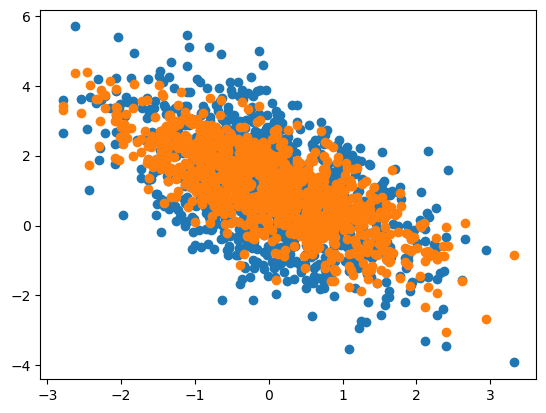

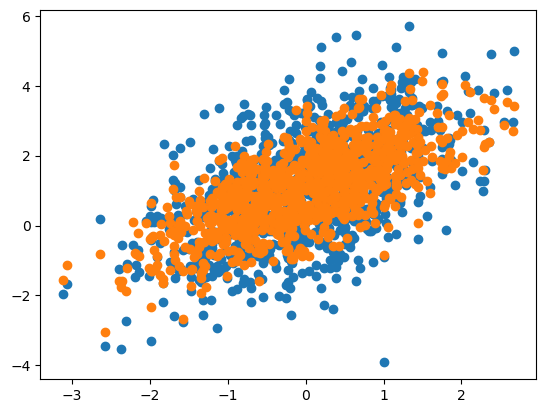

In [50]:
model = LinearRegression()
model.fit(X, y, 1e-3, 10000)
y_preds = model.predict(X)
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 0], y_preds)
plt.show()
plt.scatter(X[:, 1], y)
plt.scatter(X[:, 1], y_preds)

In [51]:
r_squared(y, y_preds)

0.5833503963288833

### Probabilistic Solution
Instead of thinking that the model produces a single value $\hat y$, think of it as producing a conditional distribution $p(y|x)$. The goal of the model is to fit the distribution  $p(y|x)$ to all the different $y$ values that are compatible with $x$. 

Let's define  $p(y|x) = \mathcal{N}(y;\hat y(x;w), \sigma^2)$. The function $\hat y(x;w)$ gives the prediction of the mean of the Gaussian. We assume that the variance $\sigma^2$ is fixed to a constant by the user. Since the examples are assumed to be i.i.d., the Conditional Log-Likelihood is given by $$\sum_{i=1}^m \log p(y^{(i)} | x^{(i)};\theta) = -m \log\sigma-\frac{m}{2}\log(2\pi)-\sum_{i=1}^m\frac{||\hat y^{(i)}-y^{(i)}||^2}{2\sigma^2}$$ where $\hat y^{(i)}$ is the output of the linear regression on the $i$-th input $x^{(i)}$ and $m$ is the number of training examples. Compare the above to what we get from mean-squared error, we see that maximizing the log-likelihood with respect to $w$ yields the same estimate of the parameters $w$ as does minimizing the mean squared error.


Assume, $y^{(i)} = \theta^\mathsf{T}x^{(i)} + \epsilon^{(i)}$
where, $\epsilon^{(i)}$ (an i.i.d. and unobservable random variable) adds noise to the linear relationship in the above equation. In linear regression, $\epsilon$ is considered to be a [[Gaussian Distribution]] with a mean of 0. That is, on average, the error is zero $\epsilon \sim \mathcal{N}(0, \sigma^2)$. That is, $P(\epsilon^{(i)}) = \frac{1}{\sqrt{2\pi\sigma}}\exp\frac{-(\epsilon^{(i)})^2}{2\sigma^2}$. This implies $P(y^{(i)}|\epsilon^{(i)};\theta) = \frac{1}{\sqrt{2\pi\sigma}}\exp\frac{-(y^{(i)}-\theta^\mathsf{T}x^{(i)})^2}{2\sigma^2}$. Note that the $\theta$ and the noise variance $\sigma^2$ are all treated as fixed (i.e., deterministic) but unknown quantities.

The goal is to find the distribution of $y^{(i)}$'s given $X$ (the design matrix which contains all $x^{(i)}$'s) and $\theta$. To view this as a function of $\theta$, we call it the likelihood function
So , $\mathcal{L}(\theta) = \mathcal{L}(\theta;X,\overrightarrow{y}) = P(\overrightarrow{y}|X;\theta)$
Since $\epsilon^{(i)}$ is i.i.d., so is $(y^{(i)}|x^{(i)})$
$
	\begin{aligned}&
		\mathcal{L}(\theta) = \prod_{i=1}^nP(y^{(i)}|x^{(i)};\theta)                                            \\&
		= \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma}}\exp\frac{-(y^{(i)}-\theta^\mathsf{T}x^{(i)})^2}{2\sigma^2} 
	\end{aligned}
$

\subsection{Maximum Likelihood Solution}
According to Maximum Likelihood]], choose $\theta$ that maximized $\mathcal{L}(\theta)$
We can instead maximize the log likelihood $l(\theta)$ since $\log$ is a strictly increasing function and will achieve the same result. This will make the derivatives easier.
$
	\begin{aligned}&
		l(\theta) = \log \mathcal{L}(\theta)                                                                                    \\&
		= \log \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma}}\exp\frac{-(y^{(i)}-\theta^\mathsf{T}x^{(i)})^2}{2\sigma^2}            \\&
		= \prod_{i=1}^n \log \frac{1}{\sqrt{2\pi\sigma}}\exp\frac{-(y^{(i)}-\theta^\mathsf{T}x^{(i)})^2}{2\sigma^2}            \\&
		= n \log \frac{1}{\sqrt{2\pi\sigma}} - \frac{1}{\sigma^2}\frac{1}{2}\sum_{i=1}^n{(y^{(i)}-\theta^\mathsf{T}x^{(i)})^2} 
	\end{aligned}
$

Hence, maximizing $l(\theta)$ gives the same answer as minimizing $\frac{1}{2}\sum_{i=1}^n{(y^{(i)}-\theta^\mathsf{T}x^{(i)})^2} = \mathcal{L}(\theta)$

\subsection{Bayesian Solution}
Given  $\hat{y} = w^{\mathsf{T}}x$ over a training set $\set{X^\mathrm{train}, y^\mathrm{train}}$ of $n$ examples, we can express a Gaussian distribution on $y$, we have $$\begin{aligned} 
p(y|X, w) &= \mathcal{N}(y;Xw, I) \\&
\propto \exp \left(-\frac{1}{2} (y-Xw)^\mathsf{T} (y-Xw)\right)
\end{aligned}$$, where we assume the standard MSE formulation assuming that the Gaussian variance $y$ is one. To determine the posterior distribution over the model parameter vector $w$, we first need to specify a prior distribution. The prior should reflect our naive belief about the values of these parameters. It is common to use the Gaussian as our prior $$p(w) = \mathcal{N}(w;\mu_0,\Lambda_0) \propto \exp\left(-\frac{1}{2}(w-\mu_0)^\mathsf{T}\Lambda_0^{-1}(w-\mu_0)\right)$$where,
- $\mu_0$ is the prior distribution mean vector
- $\Lambda_0$ is the prior distribution covariance matrix

We can now define the posterior distribution over the model parameters 
$$\begin{aligned}
p(w|X,y) &\propto p(y|X,w)p(w) \\
&\propto \exp\left(-\frac{1}{2}(y-Xw)^\mathsf{T}(y-Xw)\right)\exp\left(-\frac{1}{2}(w-\mu_0)^\mathsf{T}\Lambda_0^{-1}(w-\mu_0)\right) \\
&\propto \exp\left(-\frac{1}{2}\left(-2y^\mathsf{T}Xw+w^\mathsf{T}X^\mathsf{T}Xw+w^\mathsf{T}\Lambda_0^{-1}w-2\mu_0^\mathsf{T}\Lambda_0^{-1}w\right)\right) \\
\end{aligned}$$
Now, we define $\Lambda_n = (X^\mathsf{T}X+\Lambda_0^{-1})^{-1}$ and $\mu_m = \Lambda_m(X^\mathsf{T}y+\Lambda_0^{-1}\mu_0)$. Using these new variables, we find that the posterior may be rewritten as a Gaussian distribution: 
$$
\begin{aligned}
	p(w|X,y) & \propto \exp\left(-\frac{1}{2}(w-\mu_n)^\mathsf{T}\Lambda^{-1}_n(w-\mu_n)+\frac{1}{2}\mu_n^\mathsf{T}\Lambda_n^{-1}\mu_n\right) \\
	         & \propto \exp\left(-\frac{1}{2}(w-\mu_n)^\mathsf{T}\Lambda^{-1}_n(w-\mu_n)\right)                                                
\end{aligned}
$$
All terms that do not include the parameter $w$ have been omitted; they are implied by the fact that the distribution must be normalized to integrate to 1. 

Examining this posterior distribution gives us some intuition for the effect of Bayesian inference. In most cases, we set $\mu_0 = 0$. if we set $\Lambda_0 = \frac{1}{\alpha}I$, then $\mu_n$ gives the same estimate of $w$ as does frequentist linear regression with a weight decay penalty of $\alpha w^\mathsf{T}w$. One difference is that the Bayesian estimate is undefined if $\alpha=0$, we are not allowed to begin the Bayesian with an infintely wide prior to $w$. The more important difference is that the Bayesian estimate provides us a covariance matrix, showing how likely all the different values of $w$ are, rather than only the estimate $w_n$. 

## Applications
Linear Regression has plenty of applications in the real world. Some of these include:
- Trend line estimation in time-series data
- Predicting crop yields based on rainfall
- Revenue forecasting
- Blood pressure increase based on drug dosage

## Advantages
- Easy and fast to train
- Works with big and small datasets (provided number of data points is greater than number of features)
- Transparent predictions
- In case of multiple independent variables, we can go with forward selection, backward elimination and step wise approach for selection of most significant independent variables.

## Disadvantages
- Multiple regression suffers from [[multicollinearity]], [[autocorrelation]], [[heteroskedasticity]]
- Linear Regression is very sensitive to [[Outliers]]. It can terribly affect the regression line and eventually the forecasted values.
- Multicollinearity can increase the variance of the coefficient estimates and make the estimates very sensitive to minor changes in the model. The result is that the coefficient estimates are unstable.

# Improvements and Comparisions

## Regularization
https://www.seas.upenn.edu/~cis5190/spring2019/lectures/04_LinearRegression.pdf

Regularization helps control the model complexity by penalizing large values of $\theta_j$. By incorporating a regularization term $\lambda$ into the cost function, we can reduce the complexity, consequently reducing overfitting of our models. There are two main ways to add regularization to our models, L1 and L2 regularizations.

## Ridge Regression 

$$\begin{aligned}&
\min_\theta \mathcal{L}(\theta) = \text{RSS}(\theta) + \lambda(\text{sum of squares of weights}) \\&
= \sum_{i=1}^n \left(y_i - \sum_{j=0}^d\theta_jx_{ij}\right)^2+\lambda\sum_{j=0}^d \theta_j^2 \\&
\text{Gradient: } \frac{\delta\mathcal{L}}{\delta{\theta}_j} = -2\sum_{i=1}^n x_{ij}\left(y_i -\sum_{k=0}^d \theta_jx_{ij} \right)+2\lambda\theta_j \\&
\text{Regularization: } \theta_j^{t+1} = \theta_j^t - \eta\left[-2\sum_{i=1}^nx_{ij}\left(y_i-\sum_{k=0}^m\theta_kx_{ik}\right)+2\lambda\theta_j\right] \\&
= (1-2\lambda\eta)\theta_j^t + 2\eta \sum_{i=1}^n x_{ij}\left(y_i -\sum_{k=0}^d \theta_jx_{ij} \right) \\&
\text{Note: }\sum_{i=1}^n x_{ij}\left(y_i -\sum_{k=0}^d \theta_jx_{ij} \right) \text{ is the same as simple linear regression}
\end{aligned}$$
The above is equivalent to reducing the weight by a factor of $(1-2\lambda\eta)$ first then applying the same update rule as simple linear regression. This makes coefficients reduce to small numbers but never $0$.


With ridge regression (ridge regularization), our loss function = $$\mathrm{OLS_Loss + \alpha * \sum_{i=1}^n a_i^2}$$
where,
- $\alpha$ is a parameter we choose through hyperparameter tuning, and it balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients. $\alpha$ controls model complexity, 
- An $\alpha = 0$ is just OLS loss
- $\alpha = \infty$ leads the coefficients to be zero
- $0 \lt \alpha \lt \infty$: The magnitude of α will decide the weightage given to different parts of objective.

In multicollinearity, even though the least squares estimates (OLS) are unbiased, their variances are large which deviates the observed value far from the true value. By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors.

`y=a+b*x+e (error term),  [error term is the value needed to correct for a prediction error between the observed and predicted value]`
`y = a+y = a + b1x1 + b2x2+....+e, for multiple independent variables.`

In a linear equation, prediction errors can be decomposed into two sub components. First is due to the **biased** and second is due to the **variance**. Prediction error can occur due to any one of these two or both components.

Ridge regression solves the multicollinearity problem through shrinkage parameter λ (lambda). Look at the equation below.
$
\arg\min_\theta||y - X\theta||_2^2 + \labda||\theta||_1
$

In this equation, we have two components. First one is least square term and other one is lambda of the summation of β2 (theta- square) where β is the coefficient. This is added to least square term in order to shrink the parameter to have a very low variance.

\subsection{Lasso Regression}

$$\begin{aligned}&
\min_\theta\mathcal{L}(\theta) = \text{RSS}(\theta) + \lambda(\text{sum of absolute value of weights}) \\&
= \sum_{i=1}^n \left(y_i - \sum_{j=0}^d\theta_jx_{ij}\right)^2+\lambda\sum_{j=0}^d |\theta_j| \\&
\end{aligned}$$
$
\arg\min_\theta||y - X\theta||_2^2 + \labda||\theta||_1
$
In this case, the gradient is not defined since absolute function is not differentiable at $x=0$. Use **coordinate descent** instead:
$$\theta_j = 
\begin{Bmatrix}
{g(\theta_{-j})+\frac{\lambda}{2}}
{\text{, if }g(\theta_{-j})\lt\frac{\lambda}{2}}\\
{0}
{\text{, if }g(\theta_{-j})\le\frac{\lambda}{2}} \\
{g(\theta_{-j})-\frac{\lambda}{2}}
{\text{, if }g(\theta_{-j})\gt\frac{\lambda}{2}}
\end{Bmatrix}$$
where,
- $\theta_{-j}$ is the difference between predicted and actual outcome considering all *but* the $j^{th}$ variable. If this value is small, it means algorithm is able to predict outcome well even without $j^{th}$ variable, thus it can be removed from the equation by setting a zero coefficient.

## Definitions
> [!INFO] Ridge Regression
> Ridge Regression is a technique used when the data suffers from multicollinearity (independent variables are highly correlated)
> Ridge regression performs ‘**L2 regularization**‘, i.e. it adds a factor of sum of squares of coefficients in the optimization objective.


## Types

## Applications
It is majorly used to prevent overfitting. Since it includes all the features, it is not very useful in case of exorbitantly high number of features, say in millions, as it will pose computational challenges.

It generally works well even in presence of highly correlated features as it will include all of them in the model but the coefficients will be distributed among them depending on the correlation.

## Advantages
It includes all (or none) of the features in the model. Thus, the major advantage of ridge regression is coefficient shrinkage and reducing model complexity.

## Disadvantages


## Important Points:
- The assumptions of this regression is same as least squared regression except normality is not to be assumed
- Ridge regression shrinks the value of coefficients but doesn’t reaches zero, which suggests no feature selection feature
- This is a regularization method and uses l2 regularization.


## Lasso Regression
With lasso regression (lasso regularization), our loss function = $$\mathrm{OLS_Loss + \alpha * \sum_{i=1}^n |a_i|}$$
where,
- $\alpha$ is a parameter we choose through hyperparameter tuning
- An $\alpha = 0$ is just OLS loss
- $\alpha = \infty$ leads the coefficients to be zero
- $0 \lt \alpha \lt \infty$: The magnitude of $\alpha$ will decide the weightage given to different parts of objective.
- $\alpha = 1$ gives us a baseline model. This phenomenon of most of the coefficients being zero is called ‘**sparsity**‘.

Similar to Ridge Regression, Lasso (Least Absolute Shrinkage and Selection Operator) also penalizes the absolute size of the regression coefficients. In addition, it is capable of reducing the variability and improving the accuracy of linear regression models.  Look at the equation below: Lasso regression differs from ridge regression in a way that it uses absolute values in the penalty function, instead of squares. This leads to penalizing (or equivalently constraining the sum of the absolute values of the estimates) values which causes some of the parameter estimates to turn out exactly zero. Larger the penalty applied, further the estimates get shrunk towards absolute zero. This results to variable selection out of given n variables.

## Definitions
> [!INFO] Lasso Regression
> LASSO stands for _Least Absolute Shrinkage and Selection Operator_. It is helpful in showing us the most important features by reducing non-significant features to 0
> Lasso regression performs **L1 regularization**, i.e. it adds a factor of sum of absolute value of coefficients in the optimization objective.

Along with shrinking coefficients, lasso performs feature selection as well.
Some of the coefficients become exactly zero, which is equivalent to the particular feature being excluded from the model.

## Algorithm

## Types

## Applications

Since it provides _sparse solutions_, it is generally the model of choice (or some variant of this concept) for modelling cases where the number of features are in millions or more. In such a case, getting a sparse solution is of great computational advantage as the features with zero coefficients can simply be ignored.

It arbitrarily selects any one feature among the highly correlated ones and reduced the coefficients of the rest to zero. Also, the chosen variable changes randomly with change in model parameters. This generally doesn’t work that well as compared to ridge regression.

## Advantages

## Disadvantages

## Important Points:
- The assumptions of lasso regression is same as least squared regression except normality is not to be assumed
- Lasso Regression shrinks coefficients to zero (exactly zero), which certainly helps in feature selection
- Lasso is a regularization method and uses l1 regularization
- If group of predictors are highly correlated, lasso picks only one of them and shrinks the others to zero

## References
[Tutorial on Ridge and Lasso Regression](https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/#three)

## Definitions

> [!INFO] ElasticNet Regression
> ElasticNet is hybrid of Lasso and Ridge Regression techniques. It is trained with L1 and L2 prior as regularizer. Elastic-net is useful when there are multiple features which are correlated. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

## Algorithm

$$\hat\beta = \arg\min_{\beta}(||y-X\beta||^2+\lambda_2||\beta||^2+\lambda_1||\beta||_1)$$


## Types

## Applications

## Advantages
A practical advantage of trading-off between Lasso and Ridge is that, it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

## Disadvantages

## Important Points:
-   It encourages group effect in case of highly correlated variables
-   There are no limitations on the number of selected variables
-   It can suffer with double shrinkage

## References

## References
- [University of Toronto - Linear Regression Notes](https://www.cs.toronto.edu/~rgrosse/courses/csc311_f20/readings/notes_on_linear_regression.pdf)
- [MIT Linear Regression Notes](https://www.mit.edu/~6.s085/notes/lecture3.pdf)
- [Multiple Linear Regression - Analysis](https://www.schmidheiny.name/teaching/ols.pdf)
- [Tutorial on Ridge and Lasso Regression](https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/#three)
- [Mathematical Derivation of Regression Models](http://www.manalhelal.com/Books/geo/LinearRegressionAnalysisTheoryandComputing.pdf)